In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
from helpers.graph import *
from helpers.geometry import *
from helpers.sweep import *
from helpers.util import *
import matplotlib.pyplot as plt
from tsp_solver.greedy import solve_tsp

%load_ext autoreload
%autoreload
%matplotlib notebook

In [2]:
width = 20
step = 50

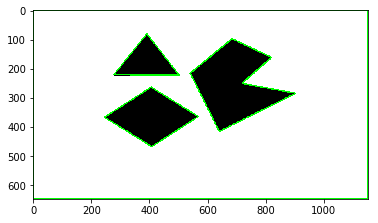

In [3]:
# img is the input image, approxes are the generated polygon
img, approxes = generate_polygon_countour("new_paint.png")
for approx in approxes:
    img = cv2.drawContours(img, [approx], 0, (0,255,0), 3)
plt.imshow(img)

In [4]:
# generate the boundary by getting the min/max value of all polygon
polygons = [np.squeeze(x) for x in approxes]

y_limit_lower = min([pt[1] for pt in polygons[0]])
y_limit_upper = max([pt[1] for pt in polygons[0]])

x_limit_lower = min([pt[0] for pt in polygons[0]])
x_limit_upper = max([pt[0] for pt in polygons[0]])

# boundary_basic certex order
boundary_basic = [[x_limit_lower, y_limit_lower], [x_limit_upper, y_limit_lower], [x_limit_upper, y_limit_upper], [x_limit_lower, y_limit_upper]]

# Among all the polygon cv2 generated, [1:] are the inner obstacles
obstacles_basic = polygons[1:]
source_basic, dest_basic = [[10, 10], [1000, 500]]

In [5]:
boundary, source, dest, sorted_vertices, obstacles = extract_vertex(boundary_basic, source_basic, dest_basic, obstacles_basic)

In [6]:
# vertices sorted in x-value
for pnt in sorted_vertices:
    print(pnt)

x = 245, y = 367, obs = 0 and test:-1
x = 278, y = 221, obs = 2 and test:-1
x = 391, y = 81, obs = 2 and test:-1
x = 406, y = 264, obs = 0 and test:-1
x = 408, y = 468, obs = 0 and test:-1
x = 502, y = 223, obs = 2 and test:-1
x = 540, y = 216, obs = 1 and test:-1
x = 568, y = 365, obs = 0 and test:-1
x = 640, y = 416, obs = 1 and test:-1
x = 684, y = 98, obs = 1 and test:-1
x = 718, y = 251, obs = 1 and test:-1
x = 820, y = 162, obs = 1 and test:-1
x = 903, y = 285, obs = 1 and test:-1


In [7]:
# reconstruct obstacles using point object
for ost in obstacles:
    for pnt in ost:
        print(pnt)

x = 406, y = 264, obs = 0 and test:-1
x = 568, y = 365, obs = 0 and test:-1
x = 408, y = 468, obs = 0 and test:-1
x = 245, y = 367, obs = 0 and test:-1
x = 684, y = 98, obs = 1 and test:-1
x = 820, y = 162, obs = 1 and test:-1
x = 718, y = 251, obs = 1 and test:-1
x = 903, y = 285, obs = 1 and test:-1
x = 640, y = 416, obs = 1 and test:-1
x = 540, y = 216, obs = 1 and test:-1
x = 278, y = 221, obs = 2 and test:-1
x = 391, y = 81, obs = 2 and test:-1
x = 502, y = 223, obs = 2 and test:-1


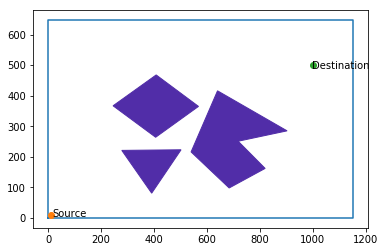

In [8]:
draw_problem(boundary, obstacles, source, dest)

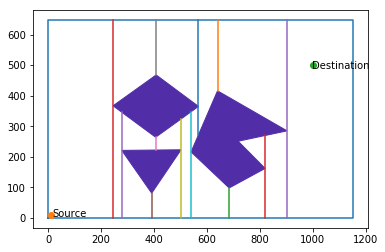

In [9]:
draw_problem(boundary, obstacles, source, dest)
open_line_segments = get_vertical_line(sorted_vertices, obstacles,  y_limit_lower, y_limit_upper)

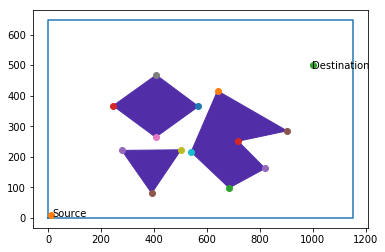

In [10]:
draw_problem(boundary, obstacles, source, dest)
#------------------------------------------------------
# Find Polygon cells naiively. Will improve next. 
# open_line_segments and sorted_vertices has the same order of points, based on the x_value
quad_cells, left_tri_cells, right_tri_cells = generate_naive_polygon(open_line_segments, sorted_vertices, obstacles)

In [11]:
print(len(quad_cells))

20


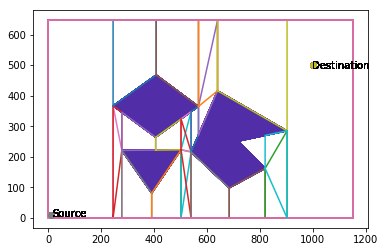

In [12]:
for i, cell in enumerate(quad_cells):
    draw_problem(boundary, obstacles, source, dest)
#     plt.figure(i)
    x = [pnt.x for pnt in cell]
    y = [pnt.y for pnt in cell]
    x.append(x[0])
    y.append(y[0])
    draw_problem(boundary, obstacles, source, dest)
    plt.plot(x, y)

In [13]:
#-------------------------------------------------------
# Merge overlapping Polygons
merge_overlapping_quad_cell(quad_cells)

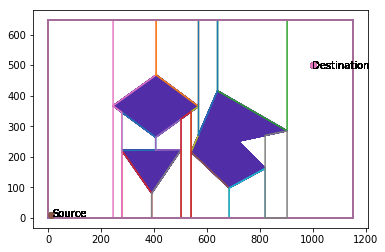

In [14]:
for i, cell in enumerate(quad_cells):
    draw_problem(boundary, obstacles, source, dest)
#     plt.figure(i)
    x = [pnt.x for pnt in cell]
    y = [pnt.y for pnt in cell]
    x.append(x[0])
    y.append(y[0])
    draw_problem(boundary, obstacles, source, dest)
    plt.plot(x, y)

In [15]:
# ------------------------------------------------------
# Add boundary lines
if( boundary[0].x != sorted_vertices[0].x):
    quad_cells.append([boundary[0], point(sorted_vertices[0].x, y_limit_lower), point(sorted_vertices[0].x, y_limit_upper), boundary[3]]);
if( boundary[1].x != sorted_vertices[len(sorted_vertices)-1].x):
    quad_cells.append([point(sorted_vertices[len(sorted_vertices)-1].x ,y_limit_lower), boundary[1], boundary[2], point(sorted_vertices[len(sorted_vertices)-1].x, y_limit_upper)]);


In [16]:
all_cell = quad_cells + left_tri_cells + right_tri_cells
# sort the cell based on teh x-value of the first point
################-----   IMPORTANT  -----##################
all_cell.sort(key = lambda pnt: pnt[0].x)

In [17]:
nodes = []
# define the type
# 1: quad_cell
# 2: left_tri_cell: left side has only one point
# 3: right_tri_cell: right side has only one point
for index, cell in enumerate(all_cell):
    if(len(cell)) == 4:
        nodes.append(node(index, cell, 1))
    elif(len(cell) == 3 and cell[1].x == cell[2].x):
        nodes.append(node(index, cell, 2))
    elif(len(cell) == 3 and cell[0].x == cell[2].x):
        nodes.append(node(index, cell, 3))
#     print("{}-th polygon:\n\ttype: {}\n\tcentroid: {}".format(index, nodes[index].type, nodes[index].centroid))
    
for curr_node in nodes:
    for next_node in nodes:
        if(next_node.index != curr_node.index):
            # define the type
            # 1: quad_cell
            # 2: left_tri_cell: left side has only one point
            # 3: right_tri_cell: right side has only one point
            
            # get adjacent nodes
            if((curr_node.type == 1 or curr_node.type == 2) and 
                (next_node.type == 1 or next_node.type == 3)):
                if(curr_node.polygon[1].x == next_node.polygon[0].x):
                    if( (max(curr_node.polygon[2].y, next_node.polygon[-1].y) - min(curr_node.polygon[1].y, next_node.polygon[0].y)) 
                         < (abs(curr_node.polygon[2].y - curr_node.polygon[1].y) + abs(next_node.polygon[-1].y - next_node.polygon[0].y)) ):
                        curr_node.add_adjacent(next_node)
    total_adjacent = curr_node.get_adjacent()
    
    # add middle point and path to adjacent node
    if(len(total_adjacent) == 1):
        curr_node.add_middle_point(centroid([curr_node.polygon[1], curr_node.polygon[2]]))
        curr_node.add_path_to_adjacency([curr_node.centroid, curr_node.middle_point[0], curr_node.adjacent[0].centroid])
        
    elif(len(total_adjacent) >= 1):
        for i, ad_node in enumerate(total_adjacent):
            curr_node.add_middle_point(centroid([ad_node.polygon[0], ad_node.polygon[-1]]))
            curr_node.add_path_to_adjacency([curr_node.centroid, curr_node.middle_point[i], curr_node.adjacent[i].centroid])
    
    # calculate the distance to the adjacent node
    curr_node.calculate_distance()
    curr_node.inside_path = sweep(curr_node.polygon, width, step)

## Merge the node that share the same boundary

In [18]:
# del_nodes = []
# # merge the polygon with same vertical boundary
# for curr_node in reversed(nodes):
#     print("current_node: " + str(curr_node.index))
#     if(len(curr_node.get_adjacent()) == 1):
#         ad_node = curr_node.get_adjacent()[0]
#         if (curr_node.type == 1 or curr_node.type == 2) and (ad_node.type == 1 or ad_node.type == 3):
#             if curr_node.polygon[1].y == ad_node.polygon[0].y and curr_node.polygon[2].y == ad_node.polygon[-1].y:
#                 print("adjacent_node: " + str(ad_node.index))
#                 curr_node.polygon = merge_polygon(curr_node.polygon + ad_node.polygon)
#                 curr_node.adjacent = ad_node.get_adjacent()
#                 curr_node.middle_point = ad_node.middle_point
                
#                 old_path = curr_node.path_to_adjaceny[0]
#                 curr_node.path_to_adjaceny = []
#                 for path in ad_node.path_to_adjaceny:
#                     print("path")
#                     curr_node.path_to_adjaceny.append(old_path + path)
                
#                 old_dist = curr_node.distance[0]
#                 curr_node.distance = []
#                 for dist in ad_node.distance:
#                     print("distance is " + str(dist))
#                     curr_node.distance.append(old_dist + dist)
#                 del_nodes.append(ad_node.index)

In [19]:
# print(del_nodes)
# del_nodes = sorted(del_nodes, reverse=True)
# for index in del_nodes:
#     nodes.pop(index)

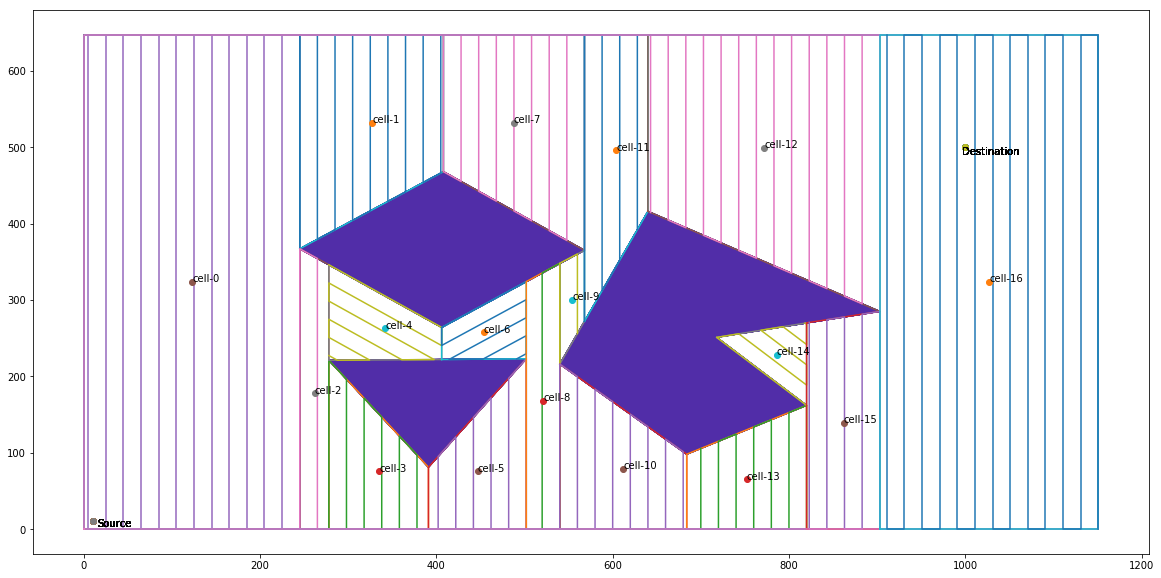

In [20]:
#-------------------------------------------------------
# Plot final cells
plt.figure(figsize=(20,10))
for index, i in enumerate(nodes):
    draw_problem(boundary, obstacles, source, dest)
#     plt.figure(index)
    x = [j.x for j in i.polygon]
    x.append(x[0])
    y = [j.y for j in i.polygon]
    y.append(y[0])
    plt.plot(x, y)
    
    path_x = [pnt.x for pnt in i.inside_path]
    path_y = [pnt.y for pnt in i.inside_path]
    plt.plot(path_x, path_y)
#     for pnt in path_pnts:
#         plt.plot(pnt.x, pnt.y, marker="o")
        
    center = centroid(i.polygon)
    plt.plot(center.x, center.y, marker="o")
    plt.annotate('cell-{}'.format(index), xy=(center.x, center.y))

In [21]:
# get the adjacency matrix
adjacency_matrix = get_adjacency_matrix(nodes)

In [22]:
# Dijkstra’s shortest path algorithm to get the shortest distance from the root to the target given adjacency matrix
# use each node as root node iteratively to generate the distance matrix

# generate a fully connected graph
num_node = len(nodes)
g = Graph(num_node)
g.graph = adjacency_matrix
g.generate_distance_st_matrix()

In [23]:
distance_matrix = np.array(g.distance_matrix)

In [24]:
# in order to use the solve_tsp command, we need to convert the distance matrix to a left_triangular_matrix
left_tri_matrix = []
for i in range(0, num_node):
    temp = list(np.split(distance_matrix[i], [i])[0])
    left_tri_matrix.append(temp)

In [25]:
# use the tsp package to get the shortest path to visit all the nodes
shortest_path_node = solve_tsp( left_tri_matrix, endpoints = (0, num_node-1) )
#will print path [0,1,2]
print(shortest_path_node)
# go back to the origin node 0
shortest_path_node.append(0)
print(shortest_path_node)

[0, 1, 7, 11, 12, 9, 8, 5, 3, 2, 4, 6, 10, 13, 15, 14, 16]
[0, 1, 7, 11, 12, 9, 8, 5, 3, 2, 4, 6, 10, 13, 15, 14, 16, 0]


In [26]:
st_path_matrix = g.st_path_matrix
new_path_node = generate_path(shortest_path_node, st_path_matrix, nodes)

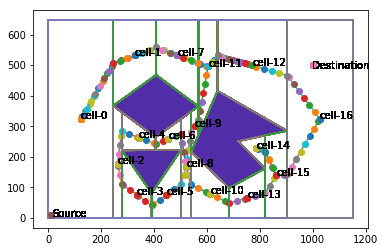

In [27]:
for i, path in enumerate(new_path_node):
#     plt.figure(i, figsize=(20,10))
    draw_node(nodes, boundary, obstacles, source, dest)
    x = [pnt.x for pnt in path]
    y = [pnt.y for pnt in path]
    plt.plot(x, y)
    
    for pnt in path:
        plt.plot(pnt.x, pnt.y, marker='o')

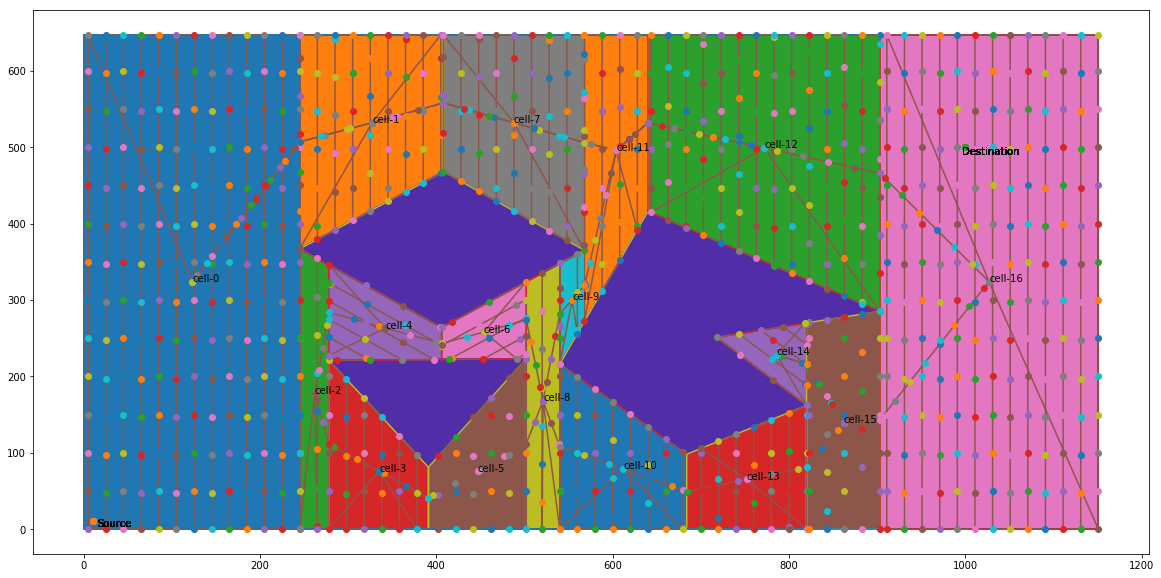

In [28]:
final_path = []
for i, node in enumerate(shortest_path_node):
    # go back to the origin node 0
    if(i < num_node):
        final_path = final_path + nodes[node].inside_path + new_path_node[i]
    
    # stay in final node
#     if(i < num_node-1):
#         final_path = final_path + nodes[node].inside_path + new_path[i]
#     else:
#         final_path = final_path + nodes[node].inside_path

plt.figure(figsize=(20,10))
draw_node(nodes, boundary, obstacles, source, dest, fill=True)
x = [pnt.x for pnt in final_path]
y = [pnt.y for pnt in final_path]
plt.plot(x, y)
for pnt in final_path:
    plt.plot(pnt.x, pnt.y, marker='o')
# print(final_path)